In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sns

In [3]:
#get images from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#dataset path to google drive
dataset_path = "/content/drive/MyDrive/datasets"
!ls $dataset_path

horses_camels_dataset.zip


In [ ]:
#unzipping the dataset
!unzip $dataset_path/horses_camels_dataset.zip

In [49]:
image_size = (224, 224)
batch_size = 32

#loading train dataset from unzipped file
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 360 files belonging to 2 classes.
Using 288 files for training.


In [50]:
#loading validation dataset from unzipped file
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 360 files belonging to 2 classes.
Using 72 files for validation.


In [51]:
#loading test dataset from unzipped file
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    image_size=image_size,
    batch_size=batch_size,
)

Found 40 files belonging to 2 classes.


In [52]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9
Number of validation samples: 3
Number of test samples: 2


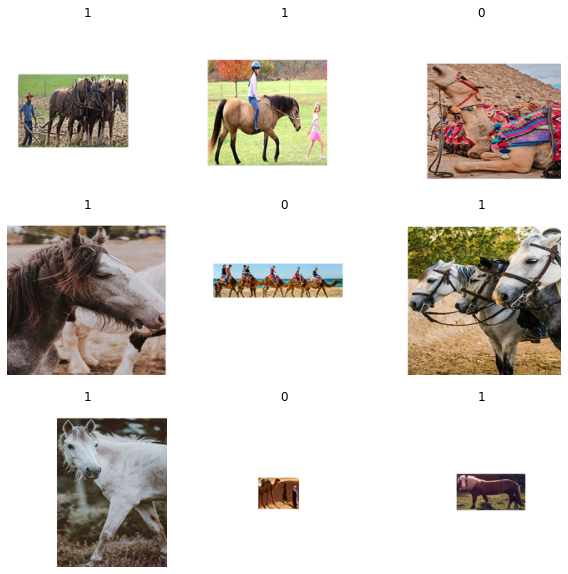

In [53]:
#displaying images: 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [62]:
#data augmentation to introduce the diversity
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

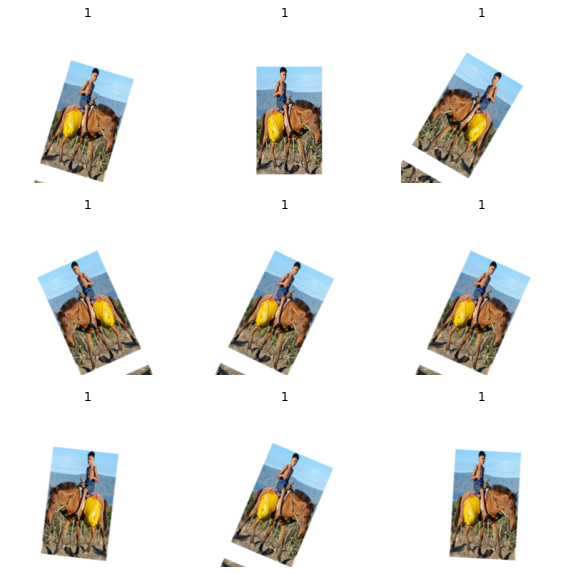

In [63]:
#augmented data displaying
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [73]:
#building a model based on available one
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
)

#freezing base_model
base_model.trainable = False

#new model creation at the top and data augmentation
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

#rescaling from (0, 255) to (-1, 1)
#outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference
# mode when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
#here is the chance to add/remove layers to identify the best architecture
x = base_model(x, training=False)

#adding layers
x = keras.layers.Conv2D(filters=64,
                        kernel_size=(7, 7),
                        padding='valid',
                        activation='relu')(inputs)
# x = keras.layers.Conv2D(filters=64,
#                         kernel_size=(7, 7),
#                         padding='valid',
#                         activation='relu')(x)
# x = keras.layers.BatchNormalization(axis=3)(x)
# x = keras.layers.Activation('relu')(x)
# x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
# x = keras.layers.MaxPooling2D((3, 3))(x)
# x = keras.layers.GlobalAveragePooling2D()(inputs))
# x = keras.layers.Flatten()(x)
# x = keras.layers.BatchNormalization()(x)
# x = layers.Activation("relu")(x)
# x = keras.layers.Dense(32)(x)
# x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024)(x)
x = layers.Activation("relu")(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(512)(x)
x = layers.Activation("relu")(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(256)(x)
x = layers.Activation("relu")(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(128)(x)
x = layers.Activation("relu")(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(64)(x)
x = layers.Activation("relu")(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 218, 218, 64)      9472      
                                                                 
 global_average_pooling2d_14  (None, 64)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_14 (Flatten)        (None, 64)                0         
                                                                 
 batch_normalization_14 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_70 (Dense)            (None, 1024)              665

In [104]:
#unfreezing the base model
base_model.trainable = True

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds)

Epoch 1/20
9/9 [==============================] - 3s 186ms/step - loss: 0.2187 - binary_accuracy: 0.9271 - val_loss: 0.9088 - val_binary_accuracy: 0.7361
Epoch 2/20
9/9 [==============================] - 2s 172ms/step - loss: 0.3155 - binary_accuracy: 0.9062 - val_loss: 1.0836 - val_binary_accuracy: 0.6389
Epoch 3/20
9/9 [==============================] - 2s 160ms/step - loss: 0.1799 - binary_accuracy: 0.9444 - val_loss: 1.0279 - val_binary_accuracy: 0.5694
Epoch 4/20
9/9 [==============================] - 2s 157ms/step - loss: 0.1762 - binary_accuracy: 0.9028 - val_loss: 0.9742 - val_binary_accuracy: 0.7083
Epoch 5/20
9/9 [==============================] - 2s 158ms/step - loss: 0.1179 - binary_accuracy: 0.9375 - val_loss: 2.2923 - val_binary_accuracy: 0.7222
Epoch 6/20
9/9 [==============================] - 2s 164ms/step - loss: 0.1930 - binary_accuracy: 0.9132 - val_loss: 9.1129 - val_binary_accuracy: 0.5833
Epoch 7/20
9/9 [==============================] - 2s 159ms/step - loss: 0.13

In [105]:
#prediction using the created model
image_batch, actucal_label = test_ds.as_numpy_iterator().next()
predicted_label = model.predict_on_batch(image_batch).flatten()

#prediction using relu
predicted_label = tf.nn.relu(predicted_label)
predicted_label = tf.where(predicted_label < 0.5, 0, 1)

print('Labels:\n', actucal_label)
print('Predicted Labels:\n', predicted_label.numpy())

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(int(predicted_label[i]))
#   plt.axis("off")

Labels:
 [0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0]
Predicted Labels:
 [1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0]


In [106]:
cnfsn_matrix = metrics.confusion_matrix(actucal_label, predicted_label.numpy())
print("Confusion matrix:\n", cnfsn_matrix)

Confusion matrix:
 [[14  2]
 [ 5 11]]


In [107]:
print("% accuracy based on Confusion matrix = ", ((cnfsn_matrix[0][0] + cnfsn_matrix[1][1]) / 
                                                  (cnfsn_matrix[0][0] + cnfsn_matrix[0][1] + cnfsn_matrix[1][0] + cnfsn_matrix[1][1]) * 100))

% accuracy based on Confusion matrix =  78.125


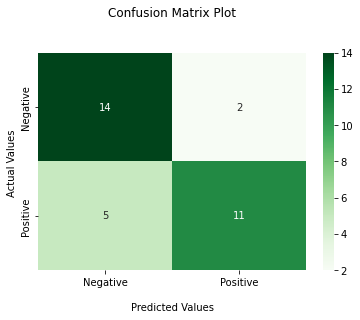

In [108]:
ax = sns.heatmap(cnfsn_matrix, annot=True, cmap='Greens')

ax.set_title('Confusion Matrix Plot\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

#labelling X & Y axis
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

plt.show()

## **Question: Which layers did you keep and which did you replace? What is the best architecture that you found?**
### **Answer:**
I have tried numerous ways to add/remove layers from the loaded pre-trained model and tested the image classification part. When I added 2 `Conv2D` models followed by `BatchNormalization` and several set of `Dense`, `Activation` using **relu** and and `Dropout` layers, the **accuracy was around 50%** as per the confusion matrix.

Finally, I came up with he above developed architecture which is showing me the **best accuracy of 78.125%**.

## **References:**
1. [https://keras.io/guides/transfer_learning/](https://keras.io/guides/transfer_learning/)
2. [https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_from_scratch.ipynb#scrollTo=6oGFV6N4W03h](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_from_scratch.ipynb#scrollTo=6oGFV6N4W03h)
3. [https://wandb.ai/authors/ayusht/reports/Image-Classification-with-Keras--VmlldzoxNTgxNjc](https://wandb.ai/authors/ayusht/reports/Image-Classification-with-Keras--VmlldzoxNTgxNjc)
4. [https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/](https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/)
5. [https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/](https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/)